# Create Network

In this repository, we will create a coauthorship network with the researchers in our database.

In [2]:
# The import order is important
import matplotlib as mpl 
mpl.use('cairo') 
%matplotlib inline 
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import itertools
import networkx as nx
from unicodedata import normalize
import json
import graph_tool.all as gt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')


/home/davi/Envs/datascience/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
authors =  pd.read_csv('./views/Authors.csv',encoding='latin-1',sep=';',index_col=0)
papers  =  pd.read_csv('./views/Papers.csv',encoding='latin-1',sep=';',index_col=0)

In [4]:
authors = authors.reset_index()
authors.head(3)

,index,@DATA-ATUALIZACAO,@NUMERO-IDENTIFICADOR,_id,NOME-COMPLETO,NOME-INSTITUICAO,UF-INSTITUICAO,PAIS-INSTITUICAO,PAIS,NOME-CITACOES,CODIGO-INSTITUICAO
0,0,2014-10-07,2.558570e+15,5d31b6f7a4ef2aef4f143ec2,Aarão Lyra,Universidade Potiguar,RN,Brasil,Brasil,"LYRA, A.;Lyra, A.;Lyra, Aarão;LYRA, A",000100000991
1,1,2017-08-01,3.172488e+15,5d31bcc1a4ef2aef4f144f75,Abdelhakim Senhaji Hafid,NaN,NaN,NaN,Marrocos,"HAFID, A. S.;A. HAFID;HAFID, ABDELHAKIM;HAFID,...",NaN
2,2,2019-09-04,2.745843e+15,5d31b766a4ef2aef4f14451d,Abdelmoubine Amar Henni,Universidade Federal de Santa Catarina,SC,Brasil,Argélia,"HENNI, A. A.;HENNI, ABDELMOUBINE AMAR;Amar Abd...",004300000009


In [5]:
papers.head(3)


,@NUMERO-IDENTIFICADOR,_id,NOME-COMPLETO,TITULO-DO-ARTIGO,ANO-DO-ARTIGO,JOURNAL,PALAVRAS-CHAVE-ARTIGO,COAUTORES,CHAVE_ARTIGO
0,6.115399e+15,5d31b5b9a4ef2aef4f14294d,Manuel Francisco Zuloeta Jimenez,"Weak almost periodic motions, minimality and s...",2014,Journal of Differential Equations (Print),Sistemas semidinâmicos Impulsivos|Weak almost ...,"[{'@NOME-COMPLETO-DO-AUTOR': 'BONOTTO, E.M.', ...",WEAKALMOSTPERIODICMOTIONSMINIMALITYANDSTABILIT...
1,6.115399e+15,5d31b5b9a4ef2aef4f14294d,Manuel Francisco Zuloeta Jimenez,"On impulsive semidynamical systems: minimal, r...",2014,Topological Methods in Nonlinear Analysis,Semidynamical systems|Minimal sets|Recurrence|...,"[{'@NOME-COMPLETO-DO-AUTOR': 'BONOTTO, E.M.', ...",ONIMPULSIVESEMIDYNAMICALSYSTEMSMINIMALRECURREN...
2,6.115399e+15,5d31b5b9a4ef2aef4f14294d,Manuel Francisco Zuloeta Jimenez,Negative trajectories in impulsive semidynamic...,2015,Journal of Differential Equations (Print),Impulsive semidinâmical systems|Negative semi ...,"[{'@NOME-COMPLETO-DO-AUTOR': 'AFONSO, S.M.', '...",NEGATIVETRAJECTORIESINIMPULSIVESEMIDYNAMICALSY...


# Creating sqlite database

In [6]:
author_paper_ids = papers[['NOME-COMPLETO','CHAVE_ARTIGO']].groupby(by=['NOME-COMPLETO',
                                                                        'CHAVE_ARTIGO']).count().reset_index()

In [7]:
schema = """
DROP TABLE IF EXISTS "author_paper";
CREATE TABLE IF NOT EXISTS "author_paper" (
    paper_id VARCHAR,
    author_id VARCHAR,
    FOREIGN KEY(paper_id) REFERENCES paper(id)
    FOREIGN KEY(author_id) REFERENCES author(id)
);
"""

In [8]:
conn = sqlite3.connect('pbmnet.sqlite',timeout=10)
cursor = conn.cursor()
cursor.executescript(schema)
conn.commit()
conn.close()

In [9]:
ins_paper_author ="""
INSERT INTO author_paper (paper_id, author_id) \
    VALUES (?,?);
"""

conn = sqlite3.connect('pbmnet.sqlite',timeout=10)
for index,row in author_paper_ids.iterrows():
    conn.execute(ins_paper_author,[row['CHAVE_ARTIGO'],row['NOME-COMPLETO']])
conn.commit()
conn.close()

# Creating edge list

In [10]:
def Generate_Edges_Authors(db):
    DATABASE = db
# Cria lista de arestas para rede de autores
    query_pair_authors = """
    SELECT paper_id,
           a1.author_id AS author1,
           a2.author_id AS author2
    FROM author_paper AS a1
    JOIN author_paper AS a2 USING (paper_id)
    WHERE a1.author_id < a2.author_id;
    """
    conn = sqlite3.connect(DATABASE,timeout=10)
    edges_authors = []
    for row in conn.execute(query_pair_authors):
        edges_authors.append(row)
    conn.close()
    edges_authors= pd.DataFrame(edges_authors,dtype=int,columns=['paper','author1',
                                                                 'author2']).applymap(lambda x: int(x))
    
    count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
    return count_authors

In [11]:
DATABASE = 'pbmnet.sqlite'
# Cria lista de arestas para rede de autores
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""
conn = sqlite3.connect(DATABASE,timeout=10)
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()

edges_authors= pd.DataFrame(edges_authors,columns=['paper','author1','author2'])

In [12]:
count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()

In [13]:
count_authors = pd.merge(count_authors,authors[['index','NOME-COMPLETO']],
                             left_on='author1',right_on='NOME-COMPLETO',how='left')

count_authors = pd.merge(count_authors,authors[['index','NOME-COMPLETO']],
                             left_on='author2',right_on='NOME-COMPLETO',how='left',suffixes=('1','2'))

In [14]:
count_authors = count_authors[['index1','index2','paper']]
count_authors.columns = ['author1','author2','paper']

In [15]:
count_authors.head()

,author1,author2,paper
0,0,1413,4
1,0,9846,1
2,2,7297,3
3,4,296,1
4,4,1096,1


In [16]:
authors_dict = authors[['index','NOME-COMPLETO','NOME-INSTITUICAO','UF-INSTITUICAO',
                         'PAIS-INSTITUICAO','PAIS',]].to_dict(orient='records')

# Creating the Network

In [17]:
def Create_Network(nodes,edges,source='source', target='target',weight='weight',name='graph'):
    G = nx.Graph(name=name)
    
    for d in nodes:
        node_id = int(d['index'])
        G.add_node(node_id, **d) 
    
    for d in edges.to_dict('records'):
        G.add_edge(d[source],d[target],count = d[weight])
    return G

In [18]:
G = Create_Network(authors_dict,count_authors,'author1','author2','paper','pbmnet')

Let's explore some basic characteristics of our network!

In [19]:
total_nodes, total_edges, avg_degree = len(G.nodes()),len(G.edges()),(2*len(G.edges())/len(G.nodes()))
print('Total Nodes = ', total_nodes)
print('Total Edges = ', total_edges)
print('Avg. Degree = ', avg_degree)

Total Nodes =  11419
Total Edges =  16164
Avg. Degree =  2.831071021980909


Degree Distribution

Text(0.5, 0, 'Degree')

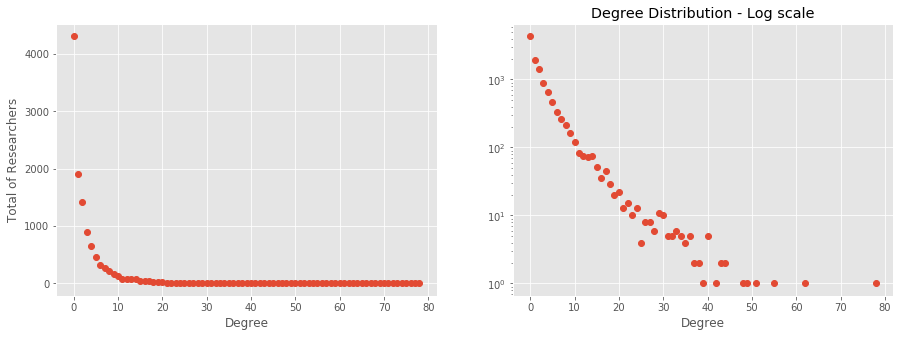

In [20]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(nx.degree_histogram(G),'o')
plt.xlabel('Degree')
plt.ylabel('Total of Researchers')
plt.subplot(122)
plt.title("Degree Distribution - Linear scale")
plt.plot(nx.degree_histogram(G),'o')
plt.yscale('log')
plt.title("Degree Distribution - Log scale")
plt.xlabel('Degree')

Let's take a look on the clustering for this network.

Avg. Clustering   =  0.20206527756060963
Median Clustering =  0.0
Avg. Clustering without zeros   =  0.5182801896820759
Median Clustering without zeros =  0.39107142857142857


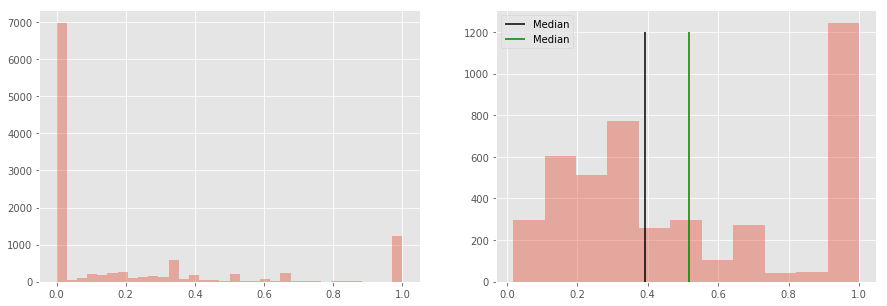

In [21]:
print('Avg. Clustering   = ', nx.average_clustering(G))
print('Median Clustering = ', np.median(list(nx.clustering(G).values())))
cluster_l0 = list(filter(lambda x: x>0,list(nx.clustering(G).values()))) # Getting values larger than 0
print('Avg. Clustering without zeros   = ', np.mean(cluster_l0))
print('Median Clustering without zeros = ', np.median(cluster_l0))

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(list(nx.clustering(G).values()),kde=False,)
plt.subplot(122)
sns.distplot(cluster_l0,kde=False,)
plt.vlines(x=np.median(cluster_l0),ymin=0,ymax=1200,label='Median')
plt.vlines(x=np.mean(cluster_l0),ymin=0,ymax=1200,label='Median',colors='g')
plt.legend()

The amount of researchers with clustering equal to 1 must be due to having only 2 or 3 connections.

Let's look at nodes with larger number of connections.

Text(0.5, 1.0, 'Degree Centralities')

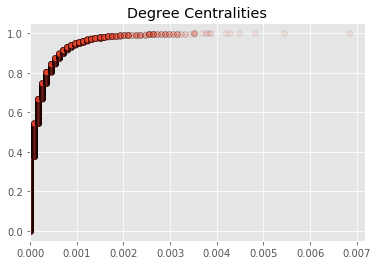

In [22]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)
# Possible Answers:
fig = plt.figure(0)
# Get a list of degree centrality scores for all of the 
# nodes in the graph
degree_centralities = list(
    nx.degree_centrality(G).values())
x, y = ecdf(degree_centralities)
# Plot the histogram of degree centralities.
plt.plot(x, y,'o',markeredgewidth=.5, markeredgecolor='k',alpha=0.10)
# Set the plot title. 
plt.xlim(0,)
plt.title('Degree Centralities')

In [23]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, bytes):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)
        print(tname,value,key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

#### Function adapted from https://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html ##

In [24]:
for u,v,d in G.edges(data=True):
    d['weight'] = d['count']/40.0

In [30]:
g = gt.Graph(directed=False)
Gsub = G.subgraph(list(range(500)))
g = nx2gt(G)

string pbmnet name


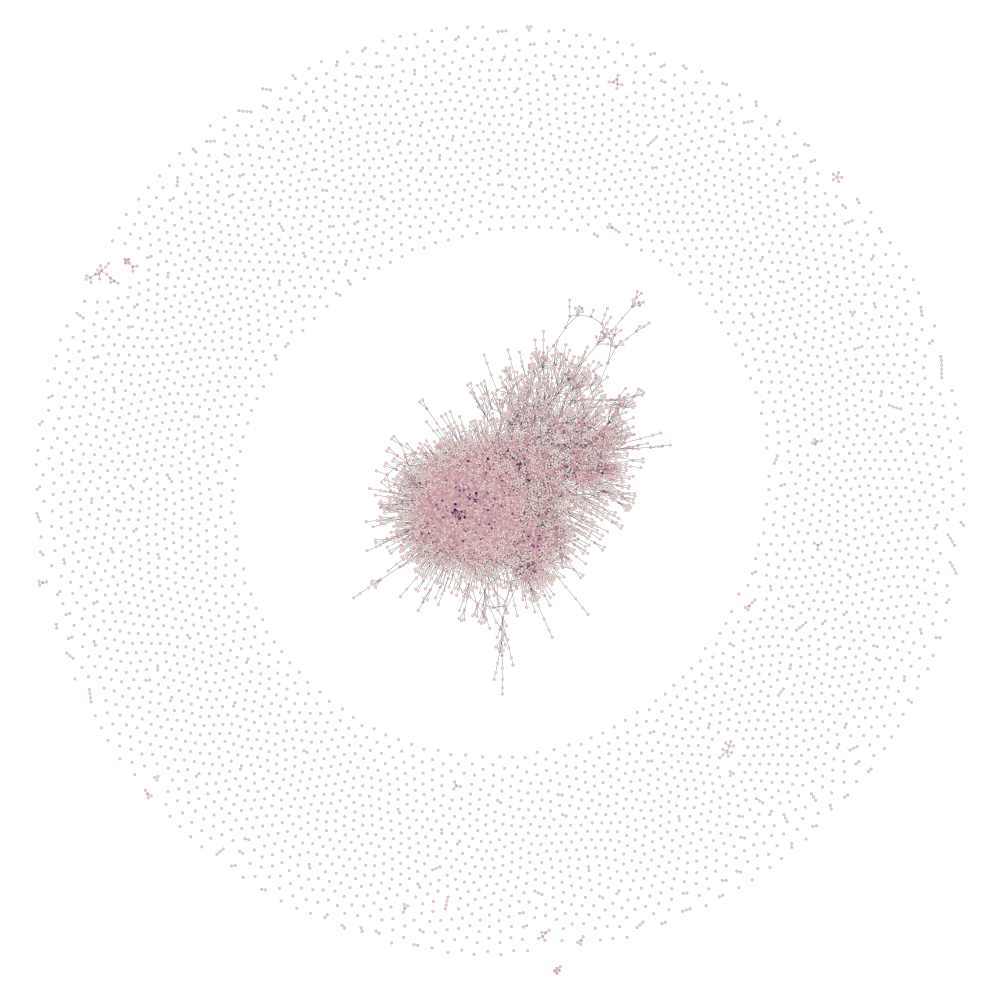

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f12f40f9e80, at 0x7f12ed01f4a8>

In [31]:
cmap = sns.cubehelix_palette(8,as_cmap=True)
deg = g.degree_property_map("total")
gt.graph_draw(g,vertex_fill_color=deg,
              vcmap=cmap,output_size=(1000,1000))#                                 orientation='horizontal')